---
title: Diversity in Recommendations - Determinantal Point Processes (DPP)
author: Aayush Agrawal
date: "2025-12-28"
categories: [Recommender Systems, Machine Learning, Diversity]
image: "dpp_cover.png"
format:
    html:
        code-fold: false
---

> Part 2 of the diversity series: Moving from greedy MMR to principled probabilistic frameworks with DPPs

<figure align = "center">
    <img src="../2025-12-25-DiversityMMRPart1/diversity.png" style="width:100%">
<figcaption align = "center">
    Figure 1: Diverse recommendations cover multiple user intents. Credit: [Gemini](https://gemini.google.com/)
</figcaption>
</figure>

:::{.callout-warning collapse="false"} 

# Disclaimer

The views expressed in this blog are solely my own and are not affiliated with my employer in any way. In writing this, I have not utilized any proprietary or confidential information.

:::

In [previous blog](https://aayushmnit.com/posts/2025-12-25-DiversityMMRPart1/DiversityMMRPart1.html), we explored MMR as a practical way to inject diversity into recommendation results. MMR works well, but it has a fundamental limitation: it's greedy and myopic. At each step, it only considers similarity to items *already selected*, not the global structure of the final set.

What if we could evaluate the diversity of an *entire set* at once? That's exactly what Determinantal Point Processes (DPPs) offer. DPPs come from probability theory and give us a principled way to assign higher probability to sets of items that are both high-quality and diverse. For example, MMR might select two sci-fi thrillers that individually seem distinct from other picks, but together make the final set feel repetitive. DPPs evaluate the whole set at once, catching this overlap.

In this post, we'll:

* Build geometric intuition for DPPs through determinants as volume
* Understand the quality-diversity decomposition for production systems
* Implement greedy MAP inference step-by-step
* Explore YouTube's production approach with tunable parameters (α, σ)
* Walk through the windowed algorithm for ranking entire feeds
* Compare DPP and MMR on our video recommendation example

# Linear Algebra Refresher: Determinants as Volume

Before diving into DPPs, we need to refresh one key concept: **determinants measure volume**.

Consider two vectors in 2D space. The determinant of the matrix formed by these vectors equals the area of the parallelogram they span.

In [2]:
#| code-fold: true
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Two similar vectors (small area)
v1 = np.array([1, 0])
v2 = np.array([0.9, 0.1])
similar_matrix = np.array([v1, v2])
print(f"Similar vectors determinant: {np.linalg.det(similar_matrix):.3f}")

# Two orthogonal vectors (maximum area)
v1 = np.array([1, 0])
v2 = np.array([0, 1])
diverse_matrix = np.array([v1, v2])
print(f"Orthogonal vectors determinant: {np.linalg.det(diverse_matrix):.3f}")

Similar vectors determinant: 0.100
Orthogonal vectors determinant: 1.000


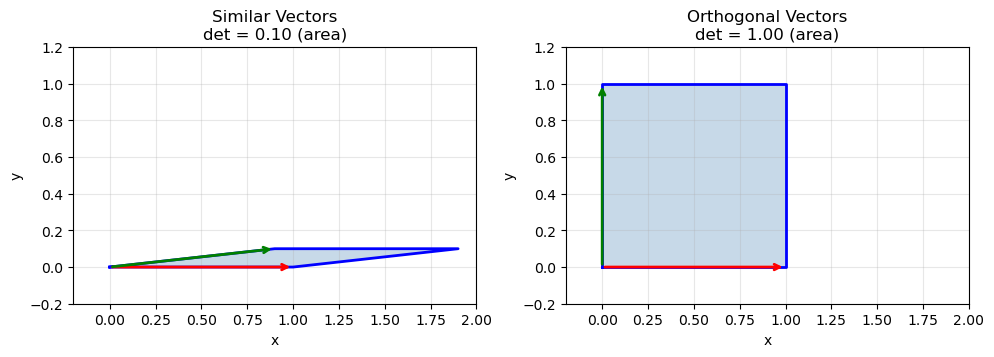

In [3]:
#| code-fold: true
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def plot_parallelogram(ax, v1, v2, title, det_val):
    v1, v2 = np.array(v1), np.array(v2)
    # Plot parallelogram
    vertices = np.array([[0, 0], v1, v1 + v2, v2, [0, 0]])
    ax.fill(vertices[:, 0], vertices[:, 1], alpha=0.3, color='steelblue')
    ax.plot(vertices[:, 0], vertices[:, 1], 'b-', linewidth=2)
    
    # Plot vectors as arrows
    ax.annotate('', xy=v1, xytext=(0, 0), arrowprops=dict(arrowstyle='->', color='red', lw=2))
    ax.annotate('', xy=v2, xytext=(0, 0), arrowprops=dict(arrowstyle='->', color='green', lw=2))
    
    ax.set_xlim(-0.2, 2.0)
    ax.set_ylim(-0.2, 1.2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{title}\ndet = {det_val:.2f} (area)")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Similar vectors
plot_parallelogram(axes[0], [1, 0], [0.9, 0.1], "Similar Vectors", 0.1)

# Orthogonal vectors  
plot_parallelogram(axes[1], [1, 0], [0, 1], "Orthogonal Vectors", 1.0)

plt.tight_layout()
plt.savefig('determinant_volume.png', dpi=150, bbox_inches='tight')
plt.show()

This is the geometric intuition behind DPPs: **diverse sets span more volume, giving them higher determinants**. When vectors point in similar directions, they span a thin, squashed parallelogram. When they're spread out, the volume is large.

This extends to higher dimensions. For *k* vectors in *d*-dimensional space, the determinant of their Gram matrix (`L = VVᵀ`) measures the squared volume of the k-dimensional parallelotope they span.

Note: Gram matrix is also called the "kernel matrix" in [DPP literature](https://arxiv.org/abs/1207.6083).

In [5]:
# 3 items in 3D feature space
items = np.array([
    [1, 0, 0],    # Item A
    [0, 1, 0],    # Item B  
    [0, 0, 1],    # Item C (diverse from A, B)
])
L = items @ items.T  # Gram matrix
print(f"Diverse set det(L): {np.linalg.det(L):.3f}")

# Replace C with something similar to A
items_similar = np.array([
    [1, 0, 0],      # Item A
    [0, 1, 0],      # Item B
    [0.8, 0.1, 0.1],  # Item C' (similar to A)
])
L_similar = items_similar @ items_similar.T
print(f"Similar set det(L): {np.linalg.det(L_similar):.3f}")

Diverse set det(L): 1.000
Similar set det(L): 0.010


The diverse set has 100x higher determinant. This is the core of DPPs: **recommendation probability proportional to determinant means diverse sets are exponentially more likely**.

# DPP Fundamentals: From Volume to Probability

Now we can define what a DPP actually is. Given a ground set of N items (our candidate pool), a DPP defines a probability distribution over all possible subsets. The key formula is:

`P(Y) ∝ det(L_Y)`

where:

- `Y` is a subset of items we might recommend
- `L` is an N×N positive semi-definite kernel matrix capturing item relationships
- `L_Y` is the submatrix of `L` indexed by items in `Y`

The probability of selecting a set is proportional to the determinant of its kernel submatrix. From our linear algebra refresher, we know determinants measure volume, so **diverse sets that span more volume get higher probability**.

Let's use the same video recommendation example from Part 1:

In [7]:
relevance = np.array([0.9, 0.85, 0.8, 0.7, 0.6, 0.5])
genre = ['Action', 'Action', 'Action', 'Comedy', 'Documentary', 'Mixed comedy/documentary']

embeddings = np.array([
    [1.0, 0.0, 0.0],   # video 0: pure action
    [0.9, 0.1, 0.0],   # video 1: action (very similar to 0)
    [0.8, 0.1, 0.1],   # video 2: action (also very similar to 0)
    [0.0, 1.0, 0.0],   # video 3: comedy
    [0.0, 0.0, 1.0],   # video 4: documentary
    [0.1, 0.5, 0.5],   # video 5: mixed
])

# Build kernel matrix L = VVᵀ (Gram matrix from embeddings)
L = embeddings @ embeddings.T
print("Kernel matrix L:")
print(np.round(L, 2))

print(f"\nSimilarity of video 0 ({genre[0]}), with other videos")
for i in range(1,len(genre)):
    print(f"Video {i}: {L[0][i]} ({genre[i]})")

Kernel matrix L:
[[1.   0.9  0.8  0.   0.   0.1 ]
 [0.9  0.82 0.73 0.1  0.   0.14]
 [0.8  0.73 0.66 0.1  0.1  0.18]
 [0.   0.1  0.1  1.   0.   0.5 ]
 [0.   0.   0.1  0.   1.   0.5 ]
 [0.1  0.14 0.18 0.5  0.5  0.51]]

Similarity of video 0 (Action), with other videos
Video 1: 0.9 (Action)
Video 2: 0.8 (Action)
Video 3: 0.0 (Comedy)
Video 4: 0.0 (Documentary)
Video 5: 0.1 (Mixed comedy/documentary)


Notice how videos 0, 1, 2 (all Action) have high similarity (~0.8-0.9), while Action vs Comedy is 0. Now let's compare the DPP probability of two different 3-video sets:

In [8]:
def subset_det(L, indices):
    """Compute det(L_Y) for a subset of indices"""
    L_Y = L[np.ix_(indices, indices)]
    return np.linalg.det(L_Y)

# Set 1: Three action videos (redundant)
redundant = [0, 1, 2]  # Action, Action, Action
det_redundant = subset_det(L, redundant)
print(f"Redundant set: {[genre[i] for i in redundant]}")
print(f"  det(L_Y) = {det_redundant:.4f}")

# Set 2: Action + Comedy + Documentary (diverse)
diverse = [0, 3, 4]
det_diverse = subset_det(L, diverse)
print(f"\nDiverse set: {[genre[i] for i in diverse]}")
print(f"  det(L_Y) = {det_diverse:.4f}")

print(f"\nDiverse set is {det_diverse/det_redundant:.0f}x more likely under DPP")

Redundant set: ['Action', 'Action', 'Action']
  det(L_Y) = 0.0001

Diverse set: ['Action', 'Comedy', 'Documentary']
  det(L_Y) = 1.0000

Diverse set is 10000x more likely under DPP


The diverse set spanning Action, Comedy, and Documentary is **10000x more likely** than picking three similar action videos! This is the DPP magic: it naturally penalizes redundancy by evaluating the entire set at once, rather than making greedy pairwise comparisons like MMR.

:::{.callout-note collapse="false"}

## Why L(Kernel Matrix) needs to be Positive Semi-Definite (PSD)

L needs to be **positive semi-definite (PSD)**. Practically, this means:

1. All eigenvalues are ≥ 0
2. Determinants of all submatrices are ≥ 0 (which we need for valid probabilities!)

**Why DPPs require PSD**: Since `P(Y) ∝ det(L_Y)`, we need `det(L_Y)` ≥ 0 for all subsets. PSD guarantees this.

**Good news for practitioners**: When you build L = VVᵀ (Gram matrix from embeddings), it's *automatically* PSD. So as long as you construct your kernel matrix as L = VVᵀ (or use standard similarity kernels like RBF), you're safe. You only run into trouble if you manually construct L with arbitrary values.

:::

# Quality vs Diversity Decomposition

So far our kernel matrix L only captures similarity between items. But in real recommendations, we care about *both* quality (relevance) and diversity. A diverse set of low-quality items is useless.

DPPs handle this elegantly through the **quality-diversity decomposition**:

`L[i,j] = q_i × q_j × S[i,j]`

where:

- `q_i` is the quality (relevance) score for item i
- `S[i,j]` is the similarity between items i and j (from embeddings)

This decomposes naturally: diagonal entries `L[i,i] = q_i²` capture item quality, while off-diagonal entries capture similarity scaled by both items' quality. High-quality similar items create larger off-diagonal terms, which *reduce* the determinant (penalizing redundancy among your best items).

Let's rebuild our kernel matrix with relevance scores:

In [9]:
# Similarity matrix from embeddings
S = embeddings @ embeddings.T

# Quality-weighted kernel: L[i,j] = q_i * q_j * S[i,j]
q = relevance.reshape(-1, 1)  # Column vector
L_quality = (q @ q.T) * S

print("Quality-weighted kernel L:")
print(np.round(L_quality, 3))

Quality-weighted kernel L:
[[0.81  0.688 0.576 0.    0.    0.045]
 [0.688 0.592 0.496 0.06  0.    0.06 ]
 [0.576 0.496 0.422 0.056 0.048 0.072]
 [0.    0.06  0.056 0.49  0.    0.175]
 [0.    0.    0.048 0.    0.36  0.15 ]
 [0.045 0.06  0.072 0.175 0.15  0.128]]


Let's compare the two sets again with the new kernel matrix:

In [10]:
redundant = [0, 1, 2]  # Top 3 by relevance, all Action
diverse = [0, 3, 4]    # Action + Comedy + Documentary

det_redundant = subset_det(L_quality, redundant)
det_diverse = subset_det(L_quality, diverse)

print(f"Redundant set (top-3 relevance): {[f'{genre[i]} ({relevance[i]})' for i in redundant]}")
print(f" det = {det_redundant:.6f}")

print(f"\nDiverse set (mixed relevance): {[f'{genre[i]} ({relevance[i]})' for i in diverse]}")
print(f" det = {det_diverse:.6f}")

print(f"\nDiverse set is {det_diverse/det_redundant:.0f}x more likely")

Redundant set (top-3 relevance): ['Action (0.9)', 'Action (0.85)', 'Action (0.8)']
 det = 0.000037

Diverse set (mixed relevance): ['Action (0.9)', 'Comedy (0.7)', 'Documentary (0.6)']
 det = 0.142884

Diverse set is 3815x more likely


Even though the diverse set includes lower-relevance items (0.7, 0.6 vs 0.85, 0.8), the diversity bonus from spanning different genres still makes it far more probable (3815x as compared to 10000x before). The quality weighting ensures we don't pick diverse but irrelevant items.

**The intuition**: Think of `q_i` as the "length" of item i's feature vector. The determinant measures the volume spanned by these vectors. A high-quality item contributes a longer vector, but if two long vectors point in the same direction (similar items), the parallelogram is still flat. You need both length (quality) AND spread (diversity) to maximize volume.

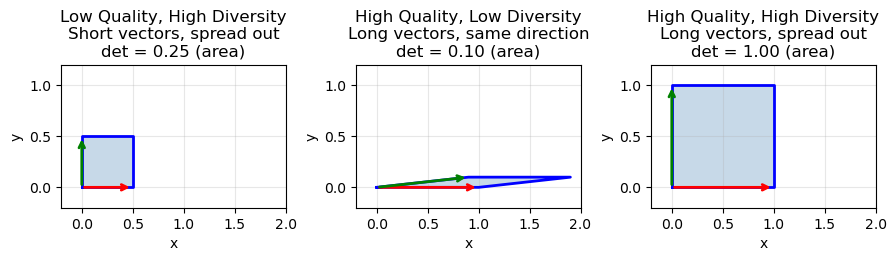

In [13]:
#| code-fold: true
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

# Case 1: Short vectors, diverse directions
plot_parallelogram(axes[0], [0.5, 0], [0, 0.5], 
    "Low Quality, High Diversity\nShort vectors, spread out", 0.25)

# Case 2: Long vectors, similar directions  
plot_parallelogram(axes[1], [1.0, 0], [0.9, 0.1],
    "High Quality, Low Diversity\nLong vectors, same direction", 0.10)

# Case 3: Long vectors, diverse directions (ideal)
plot_parallelogram(axes[2], [1.0, 0], [0, 1.0],
    "High Quality, High Diversity\nLong vectors, spread out", 1.00)

plt.tight_layout()
plt.savefig('quality_diversity_volume.png', dpi=150, bbox_inches='tight')
plt.show()

This maps directly to production recsys:

* `q_i` = your relevance model output (e.g., predicted click probability)
* `S[i,j]` = Similarity of content embeddings (or 1 - distance in any embedding space)
* `L` = the kernel that balances both signals

# Greedy MAP: The Practical DPP Algorithm

We've established that DPPs assign higher probability to diverse, high-quality sets via determinants. The natural question: how do we find the best set?

**The challenge**: Finding the subset `Y` that maximizes `det(L_Y)` is called **MAP (Maximum A Posteriori) inference**. With N candidates, there are `2^N` possible subsets. This is NP-hard in general.

**The solution**: **Greedy MAP approximation**. Build the set one item at a time, always adding whichever item increases the determinant most. This runs in `O(Nk³)` time and provides provably good approximations, where N is the number of candidates to select from and k is the number of items to select.

## Walking Through Greedy MAP Step-by-Step

Let's trace through selecting 3 videos from our candidate pool. At each step, we try adding every remaining candidate and pick whoever maximizes `det(L_Y)`.

**Step 1: First Selection**

With an empty set, we're just comparing single-item determinants. For a 1×1 matrix, `det([L[i,i]]) = L[i,i] = q_i²`. So the first pick is simply the highest-quality item:

In [25]:
#| code-fold: false
print("Step 1: Evaluating single-item determinants (= quality squared)")
for i in range(len(relevance)):
    det_single = L_quality[i, i]
    print(f"  Video {i} ({genre[i]}): det = {det_single:.3f} (relevance² = {relevance[i]**2:.3f})")

first_pick = int(np.argmax([L_quality[i,i] for i in range(len(relevance))]))
print(f"\n→ Select video {first_pick} ({genre[first_pick]})")

Step 1: Evaluating single-item determinants (= quality squared)
  Video 0 (Action): det = 0.810 (relevance² = 0.810)
  Video 1 (Action): det = 0.592 (relevance² = 0.722)
  Video 2 (Action): det = 0.422 (relevance² = 0.640)
  Video 3 (Comedy): det = 0.490 (relevance² = 0.490)
  Video 4 (Documentary): det = 0.360 (relevance² = 0.360)
  Video 5 (Mixed comedy/documentary): det = 0.128 (relevance² = 0.250)

→ Select video 0 (Action)


**Step 2: Second Selection**

Now it gets interesting. We evaluate each remaining candidate by computing `det(L_Y)` for the 2-item set:

In [26]:
#| code-fold: false
selected = [first_pick]
print(f"Step 2: Current set = [Video {first_pick}]")
print("Evaluating candidates:")

for candidate in range(len(relevance)):
    if candidate in selected:
        continue
    
    subset = selected + [candidate]
    L_subset = L_quality[np.ix_(subset, subset)]
    det_val = np.linalg.det(L_subset)
    
    # Show the 2x2 matrix being evaluated
    print(f"\n  Video {candidate} ({genre[candidate]}):")
    print(f"    L_subset = [[{L_subset[0,0]:.3f}, {L_subset[0,1]:.3f}],")
    print(f"                [{L_subset[1,0]:.3f}, {L_subset[1,1]:.3f}]]")
    print(f"    det = {L_subset[0,0]:.3f} × {L_subset[1,1]:.3f} - {L_subset[0,1]:.3f} × {L_subset[1,0]:.3f} = {det_val:.4f}")

Step 2: Current set = [Video 0]
Evaluating candidates:

  Video 1 (Action):
    L_subset = [[0.810, 0.689],
                [0.689, 0.592]]
    det = 0.810 × 0.592 - 0.689 × 0.689 = 0.0059

  Video 2 (Action):
    L_subset = [[0.810, 0.576],
                [0.576, 0.422]]
    det = 0.810 × 0.422 - 0.576 × 0.576 = 0.0104

  Video 3 (Comedy):
    L_subset = [[0.810, 0.000],
                [0.000, 0.490]]
    det = 0.810 × 0.490 - 0.000 × 0.000 = 0.3969

  Video 4 (Documentary):
    L_subset = [[0.810, 0.000],
                [0.000, 0.360]]
    det = 0.810 × 0.360 - 0.000 × 0.000 = 0.2916

  Video 5 (Mixed comedy/documentary):
    L_subset = [[0.810, 0.045],
                [0.045, 0.128]]
    det = 0.810 × 0.128 - 0.045 × 0.045 = 0.1013


Notice how adding another Action video (high off-diagonal similarity) leads to a lower determinant, while Comedy or Documentary (zero similarity to Action) leads to a higher determinant. In this case we will pick Video 3 as it has the highest determinant of `0.3969`.

In [27]:
#| code-fold: false
# Find second pick
best_det, second_pick = -1, None
for candidate in range(len(relevance)):
    if candidate in selected:
        continue
    subset = selected + [candidate]
    det_val = np.linalg.det(L_quality[np.ix_(subset, subset)])
    if det_val > best_det:
        best_det, second_pick = det_val, candidate

print(f"\n→ Select video {second_pick} ({genre[second_pick]}), det = {best_det:.4f}")
selected.append(second_pick)


→ Select video 3 (Comedy), det = 0.3969


**Step 3: Third Selection**

Same process with a 3×3 determinant:

In [28]:
#| code-fold: false
print(f"Step 3: Current set = {selected}")
print("Evaluating candidates:")

for candidate in range(len(relevance)):
    if candidate in selected:
        continue
    
    subset = selected + [candidate]
    det_val = np.linalg.det(L_quality[np.ix_(subset, subset)])
    print(f"  Video {candidate} ({genre[candidate]}): det = {det_val:.4f}")

# Find third pick
best_det, third_pick = -1, None
for candidate in range(len(relevance)):
    if candidate in selected:
        continue
    subset = selected + [candidate]
    det_val = np.linalg.det(L_quality[np.ix_(subset, subset)])
    if det_val > best_det:
        best_det, third_pick = det_val, candidate

selected.append(third_pick)
print(f"\n→ Select video {third_pick} ({genre[third_pick]})")
print(f"\nFinal selection: {[genre[i] for i in selected]}")

Step 3: Current set = [0, 3]
Evaluating candidates:
  Video 1 (Action): det = 0.0000
  Video 2 (Action): det = 0.0025
  Video 4 (Documentary): det = 0.1429
  Video 5 (Mixed comedy/documentary): det = 0.0248

→ Select video 4 (Documentary)

Final selection: ['Action', 'Comedy', 'Documentary']


## The Complete Implementation

Now we can wrap this into a clean function:

In [23]:
def greedy_map_dpp(L, k):
    N = L.shape[0]
    selected = []
    remaining = set(range(N))
    
    for _ in range(k):
        best_item, best_det = None, -1
        
        for item in remaining:
            candidate_set = selected + [item]
            det_val = np.linalg.det(L[np.ix_(candidate_set, candidate_set)])
            
            if det_val > best_det:
                
                best_det = det_val
                best_item = item
        
        selected.append(best_item)
        remaining.remove(best_item)
    
    return selected

# Run it
result = greedy_map_dpp(L_quality, k=3)
print(f"Greedy MAP result: {[f'{genre[i]} ({relevance[i]})' for i in result]}")

Greedy MAP result: ['Action (0.9)', 'Comedy (0.7)', 'Documentary (0.6)']


Pure relevance ranking would give us Action, Action, Action. DPP gives us Action, Comedy, Documentary. Three genres covered in three slots.

# Tuning the Quality-Diversity Tradeoff

In production, you need a way to control how much the system emphasizes relevance versus diversity. YouTube's approach, described in their [2018 paper on DPPs for recommendations](https://dl.acm.org/doi/epdf/10.1145/3269206.3272018), provides a clean parameterization that's proven to work at scale.

## YouTube's Kernel Parameterization

<figure align = "center">
    <img src="./kernel_formula_dpp.png" style="width:100%">
<figcaption align = "center">
    Figure 2: Snapshot of DPP kenel matrix formulation from  [YT DPP paper](https://dl.acm.org/doi/epdf/10.1145/3269206.3272018)
</figcaption>
</figure>

Instead of the simple `L[i,j] = q_i × q_j × S[i,j]` formulation, YouTube uses:

`L[i,i] = q_i²` (diagonal: quality squared)

`L[i,j] = α × q_i × q_j × exp(-D_ij / 2σ²)` for `i ≠ j` (off-diagonal: scaled similarity)

where:

- `q_i` is the relevance score for item i
- `D_ij` is the distance between items i and j in embedding space
- `α` controls the overall strength of diversity (0 ≤ α ≤ 1)
- `σ` controls the length scale of similarity

**The key insight**: The diagonal entries (quality) remain unchanged, but off-diagonal entries (similarity) are scaled by α. This gives you direct control over the diversity penalty.

:::{.callout-note collapse="false"} 
Note: This formulation is identical to a standard (Gaussian) radial basis function (RBF) kernel when α = 1.
:::

## Understanding the Parameters

**α (diversity strength)**:

- α = 1: Full diversity penalty. Similar items strongly repel each other.
- α = 0: No diversity penalty. Reduces to pure relevance ranking.
- α ∈ (0,1): Smooth tradeoff between quality and diversity.

**σ (similarity scale)**:

- Small σ: Only very similar items are considered redundant (tight clusters).
- Large σ: Even moderately different items are penalized (broad diversity).

Let's implement this new kernel building function:

In [30]:
def youtube_dpp_kernel(relevance, embeddings, alpha=0.5, sigma=1.0):
    N = len(relevance)
    L = np.zeros((N, N))
    
    # Compute pairwise distances
    # D_ij = ||embedding_i - embedding_j||²
    for i in range(N):
        for j in range(N):
            if i == j:
                # Diagonal: quality squared
                
                L[i, i] = relevance[i] ** 2
            else:
                # Off-diagonal: scaled similarity with RBF kernel
                D_ij = np.sum((embeddings[i] - embeddings[j]) ** 2)
                similarity = np.exp(-D_ij / (2 * sigma**2))
                L[i, j] = alpha * relevance[i] * relevance[j] * similarity
    
    return L

# Build kernel with YouTube's approach
L_youtube = youtube_dpp_kernel(relevance, embeddings, alpha=0.5, sigma=1.0)

print("YouTube DPP kernel (α=0.5, σ=1.0):")
print(np.round(L_youtube, 3))

YouTube DPP kernel (α=0.5, σ=1.0):
[[0.81  0.379 0.349 0.116 0.099 0.117]
 [0.379 0.722 0.337 0.132 0.103 0.126]
 [0.349 0.337 0.64  0.135 0.116 0.133]
 [0.116 0.132 0.135 0.49  0.077 0.136]
 [0.099 0.103 0.116 0.077 0.36  0.116]
 [0.117 0.126 0.133 0.136 0.116 0.25 ]]


## Sweeping the α Parameter

Let's see how α affects the diversity-quality tradeoff:

In [34]:
#| code-fold: true
print("\nα parameter sweep (σ=1.0 fixed):")
print(f"{'α':<6} {'Selected Items':<50} {'Genres':<40}")
print("-" * 95)

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]

for alpha in alphas:
    L_alpha = youtube_dpp_kernel(relevance, embeddings, alpha=alpha, sigma=1.0)
    selected = greedy_map_dpp(L_alpha, k=3)
    items_str = ", ".join([f"V{i}({relevance[i]:.2f})" for i in selected])
    genres_str = ", ".join([genre[i] for i in selected])
    print(f"{alpha:<6.2f} {items_str:<50} {genres_str:<40}")


α parameter sweep (σ=1.0 fixed):
α      Selected Items                                     Genres                                  
-----------------------------------------------------------------------------------------------
0.00   V0(0.90), V1(0.85), V2(0.80)                       Action, Action, Action                  
0.25   V0(0.90), V1(0.85), V2(0.80)                       Action, Action, Action                  
0.50   V0(0.90), V1(0.85), V3(0.70)                       Action, Action, Comedy                  
0.75   V0(0.90), V3(0.70), V4(0.60)                       Action, Comedy, Documentary             
1.00   V0(0.90), V3(0.70), V4(0.60)                       Action, Comedy, Documentary             


**Key observations**:

- **α = 0.0–0.25**: Pure relevance ranking. Off-diagonal terms are too weak to overcome quality differences, so we get the top-3 by relevance (all Action).
- **α = 0.5**: Moderate diversity kicks in. The algorithm trades Video 2 (Action, 0.80) for Video 3 (Comedy, 0.70), accepting a small relevance drop for genre diversity.
- **α = 0.75–1.0**: Strong diversity preference. The algorithm maximizes spread across genres (Action, Comedy, Documentary), dropping Video 1 (Action, 0.85) in favor of lower-relevance items from different genres.

The transition happens around α = 0.5, where the diversity penalty becomes strong enough to outweigh small relevance differences. In production, you'd tune α based on metrics like session diversity, user engagement, or A/B test results.

## Sweeping the σ Parameter

The σ parameter controls what counts as "similar". Let's fix α = 0.75 and vary σ:

In [33]:
#| code-fold: true
print("\nσ parameter sweep (α=0.75 fixed):")
print(f"{'σ':<6} {'Selected Items':<50} {'Genres':<40}")
print("-" * 95)

sigmas = [0.1, 0.5, 1.0, 2.0, 5.0]

for sigma in sigmas:
    L_sigma = youtube_dpp_kernel(relevance, embeddings, alpha=0.75, sigma=sigma)
    selected = greedy_map_dpp(L_sigma, k=3)
    items_str = ", ".join([f"V{i}({relevance[i]:.2f})" for i in selected])
    genres_str = ", ".join([genre[i] for i in selected])
    print(f"{sigma:<6.1f} {items_str:<50} {genres_str:<40}")


σ parameter sweep (α=0.75 fixed):
σ      Selected Items                                     Genres                                  
-----------------------------------------------------------------------------------------------
0.1    V0(0.90), V1(0.85), V2(0.80)                       Action, Action, Action                  
0.5    V0(0.90), V3(0.70), V4(0.60)                       Action, Comedy, Documentary             
1.0    V0(0.90), V3(0.70), V4(0.60)                       Action, Comedy, Documentary             
2.0    V0(0.90), V3(0.70), V1(0.85)                       Action, Comedy, Action                  
5.0    V0(0.90), V1(0.85), V2(0.80)                       Action, Action, Action                  


**Key observations**:

- **σ = 0.1**: Very tight similarity threshold. Only near-identical items are penalized as redundant, so the diversity effect barely activates. Result: top-3 by relevance (all Action).
- **σ = 0.5–1.0**: Moderate similarity scale. Items within the same genre are considered similar enough to penalize, leading to genre mixing (Action, Comedy, Documentary).
- **σ = 2.0**: Broader similarity scale. Even moderately different items start to look similar. The algorithm becomes more willing to sacrifice relevance for diversity.
- **σ = 5.0**: Very broad similarity scale. Almost everything looks similar, which actually weakens the diversity signal. The algorithm struggles to distinguish between items and reverts toward relevance-based ranking.

In practice, σ should match the natural scale of your embedding space. If your embeddings are normalized (unit length), σ ≈ 1.0 is a reasonable starting point. Tune it based on how strict you want diversity: smaller σ for subtle redundancy detection within tight clusters, larger σ for aggressive spreading across broader categories.

## Visualizing the RBF Kernel

The `exp(-D_ij / 2σ²)` term is an RBF (Radial Basis Function) kernel. Let's visualize how it maps distances to similarities:

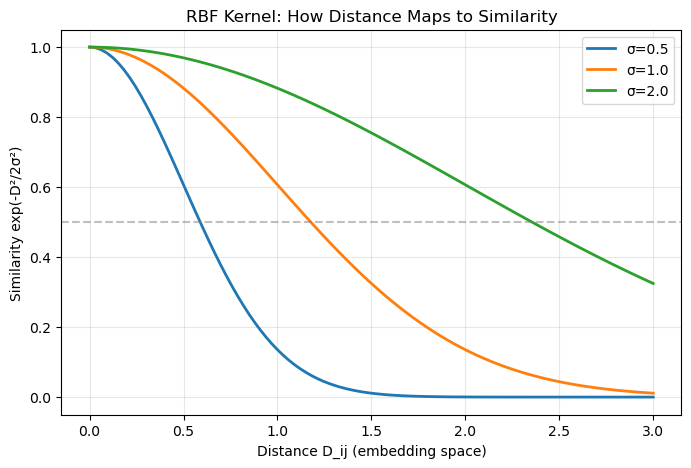

In [35]:
#| code-fold: true
fig, ax = plt.subplots(figsize=(8, 5))

distances = np.linspace(0, 3, 100)

for sigma in [0.5, 1.0, 2.0]:
    similarities = np.exp(-distances**2 / (2 * sigma**2))
    ax.plot(distances, similarities, label=f'σ={sigma}', linewidth=2)

ax.set_xlabel('Distance D_ij (embedding space)')
ax.set_ylabel('Similarity exp(-D²/2σ²)')
ax.set_title('RBF Kernel: How Distance Maps to Similarity')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.savefig('rbf_kernel.png', dpi=150, bbox_inches='tight')
plt.show()

**Interpretation**: With σ = 1.0, items at distance 1.0 have similarity ≈ 0.6 (moderate penalty), while items at distance 2.0 have similarity ≈ 0.14 (weak penalty). Smaller σ makes the kernel "sharper" — only very close items are considered similar.

## Practical Guidance

**Tuning strategy**:

1. **Start with α = 0.5, σ = 1.0**: This is a reasonable default that balances quality and diversity.

2. **Tune α first**:
   - Sweep α ∈ [0.2, 0.8] in 0.1 increments
   - Measure offline diversity metrics (intra-list distance, genre entropy) vs relevance metrics (nDCG)
   - Plot the Pareto frontier to find acceptable tradeoffs

3. **Then tune σ**:
   - If items are still too similar, decrease σ (tighter similarity definition)
   - If diversity is too aggressive, increase σ (looser similarity definition)
   - σ should roughly match the typical distance scale in your embedding space

4. **A/B test top candidates**: Run online experiments with 2-3 (α, σ) pairs to validate offline metrics.

**Typical values in production**:

- Balanced systems: α ≈ 0.4-0.6, σ ≈ 0.5-1.5
- Quality-focused (e.g., search): α ≈ 0.2-0.4
- Discovery-focused (e.g., explore page): α ≈ 0.6-0.9

The beauty of YouTube's parameterization is that it decouples quality (diagonal) from diversity (off-diagonal), giving you two independent knobs to tune the system behavior.

# YouTube's Production DPP Implementation

The greedy MAP algorithm we implemented earlier works well for selecting a fixed top-k set. However, YouTube's production system needs to rank entire feeds of hundreds or thousands of videos. Their [2018 paper](https://dl.acm.org/doi/epdf/10.1145/3269206.3272018) introduces a **windowed approach** that processes candidates in batches, making DPPs scalable for large-scale recommendation systems.

## The Windowed Algorithm

Instead of selecting all k items at once from the full candidate pool, YouTube's algorithm:

1. **Selects k items** from the current candidate pool using greedy MAP
2. **Adds them to the result list** R
3. **Removes selected items** from the pool and updates the kernel matrix
4. **Repeats** until all candidates are ranked (or enough items are selected)

This approach has several advantages:

- **Scalability**: Processes N items in O(Nk²) time instead of O(Nk³)
- **Diversity within pages**: Ensures each "window" of k items is diverse, not just the top-k
- **Memory efficiency**: Can process large pools without computing full N×N kernels
- **Flexibility**: Can stop early after ranking enough items for the user's viewport

Here's the algorithm from YouTube's paper:

<figure align = "center">
    <img src="./yt_dpp.png" style="width:100%">
<figcaption align = "center">
    Figure 3: Snapshot of DPP algorithm from  [YT DPP paper](https://dl.acm.org/doi/epdf/10.1145/3269206.3272018)
</figcaption>
</figure>

In [41]:
def youtube_dpp_ranking(relevance, embeddings, k, alpha=0.5, sigma=1.0):
    W = list(range(len(relevance)))  # Remaining candidate indices
    R = []  # Final ranked list
    
    while len(W) > 0:
        # Build kernel for current candidate pool
        rel_W = relevance[W]
        emb_W = embeddings[W]
        L = youtube_dpp_kernel(rel_W, emb_W, alpha=alpha, sigma=sigma)
        
        # Select up to k items from current pool
        window_size = min(k, len(W))
        M = greedy_map_dpp(L, k=window_size)
        
        # Map back to original indices
        selected_items = [W[i] for i in M]
        R.extend(selected_items)
        
        # Remove selected items from candidate pool
        W = [w for w in W if w not in selected_items]
    
    return R

## Walking Through the Windowed Algorithm

Let's trace through ranking all 6 videos with window size k=2:

In [40]:
#| code-fold: true
print("YouTube Windowed DPP (k=2, α=0.75, σ=1.0)")
print("=" * 70)

# We'll manually trace the first few iterations
W = list(range(len(relevance)))
R = []
k_window = 2
alpha, sigma = 0.75, 1.0

iteration = 1
while len(W) > 0 and iteration <= 3:  # Show first 3 iterations
    print(f"\nIteration {iteration}:")
    print(f"  Remaining pool W: {W}")
    print(f"  Pool genres: {[genre[i] for i in W]}")
    
    # Build kernel for current pool
    rel_W = relevance[W]
    emb_W = embeddings[W]
    L = youtube_dpp_kernel(rel_W, emb_W, alpha=alpha, sigma=sigma)
    
    # Select k items
    window_size = min(k_window, len(W))
    M = greedy_map_dpp(L, k=window_size)
    selected_items = [W[i] for i in M]
    
    print(f"  Selected from pool: {M} (pool indices)")
    print(f"  Maps to original: {selected_items}")
    print(f"  Genres: {[genre[i] for i in selected_items]}")
    print(f"  Relevance: {[relevance[i] for i in selected_items]}")
    
    R.extend(selected_items)
    W = [w for w in W if w not in selected_items]
    
    iteration += 1

print(f"\n{'─'*70}")
print(f"Final ranking R: {R}")
print(f"Genres: {[genre[i] for i in R]}")

YouTube Windowed DPP (k=2, α=0.75, σ=1.0)

Iteration 1:
  Remaining pool W: [0, 1, 2, 3, 4, 5]
  Pool genres: ['Action', 'Action', 'Action', 'Comedy', 'Documentary', 'Mixed comedy/documentary']
  Selected from pool: [0, 3] (pool indices)
  Maps to original: [0, 3]
  Genres: ['Action', 'Comedy']
  Relevance: [np.float64(0.9), np.float64(0.7)]

Iteration 2:
  Remaining pool W: [1, 2, 4, 5]
  Pool genres: ['Action', 'Action', 'Documentary', 'Mixed comedy/documentary']
  Selected from pool: [0, 2] (pool indices)
  Maps to original: [1, 4]
  Genres: ['Action', 'Documentary']
  Relevance: [np.float64(0.85), np.float64(0.6)]

Iteration 3:
  Remaining pool W: [2, 5]
  Pool genres: ['Action', 'Mixed comedy/documentary']
  Selected from pool: [0, 1] (pool indices)
  Maps to original: [2, 5]
  Genres: ['Action', 'Mixed comedy/documentary']
  Relevance: [np.float64(0.8), np.float64(0.5)]

──────────────────────────────────────────────────────────────────────
Final ranking R: [0, 3, 1, 4, 2, 5]
Gen

**Key observations**:

- **Iteration 1**: From the full pool, selects the highest-quality Action video (0.9) and highest-quality diverse option (Comedy, 0.7)
- **Iteration 2**: From remaining items, selects another Action video (0.85) paired with Documentary (0.6) for diversity
- **Iteration 3**: Clears the remaining pool with the last Action and Mixed genre video

Notice how diversity is enforced **within each window of 2 items**, not just globally. This ensures users see varied content throughout their feed, not just at the top.

## Comparing Single-Pass vs Windowed

Let's compare the two approaches side-by-side:

In [42]:
#| code-fold: true
# Single-pass: select top-3 from full pool at once
L_full = youtube_dpp_kernel(relevance, embeddings, alpha=0.75, sigma=1.0)
single_pass = greedy_map_dpp(L_full, k=3)

# Windowed: select in windows of k=2
windowed_result = youtube_dpp_ranking(relevance, embeddings, k=2, alpha=0.75, sigma=1.0)

print("Comparison of top-3 selections:")
print(f"{'Method':<20} {'Indices':<15} {'Genres':<50} {'Relevance'}")
print("─" * 100)

single_genres = [genre[i] for i in single_pass]
single_rel = [float(relevance[i]) for i in single_pass]
print(f"{'Single-pass':<20} {str(single_pass):<15} {', '.join(single_genres):<50} {single_rel}")

windowed_top3 = windowed_result[:3]
windowed_genres = [genre[i] for i in windowed_top3]
windowed_rel = [float(relevance[i]) for i in windowed_top3]
print(f"{'Windowed (k=2)':<20} {str(windowed_top3):<15} {', '.join(windowed_genres):<50} {windowed_rel}")

Comparison of top-3 selections:
Method               Indices         Genres                                             Relevance
────────────────────────────────────────────────────────────────────────────────────────────────────
Single-pass          [0, 3, 4]       Action, Comedy, Documentary                        [0.9, 0.7, 0.6]
Windowed (k=2)       [0, 3, 1]       Action, Comedy, Action                             [0.9, 0.7, 0.85]


The windowed approach includes Video 1 (Action, 0.85) in the top-3 because it was selected in the second window after Videos 0 and 3 were removed. This demonstrates how window size k affects the ranking: smaller windows enforce local diversity but may allow similar items to appear nearby across window boundaries.

In the paper, it's mentioned that typically the candidate pool is several hundreds of videos and sub-window size is a dozen (12) or so videos.

The windowed algorithm is YouTube's production solution for bringing the mathematical elegance of DPPs to real-world scale. By processing items in batches, it maintains diversity guarantees while handling feeds with thousands of candidates in milliseconds.

# System Design Integration

Now that we've covered DPP theory and implementation, let's see how it fits into a production recommendation system. Recall from [Part 1](https://aayushmnit.com/posts/2025-12-25-DiversityMMRPart1/DiversityMMRPart1.html#system-design-integration) the standard recommendation pipeline:

<figure align = "center">
    <img src="./dpp_pipeline.png" style="width:100%">
<figcaption align = "center">
    Figure 4: Typical RecSys pipeline showing where DPP fits in the recommendation pipeline
</figcaption>
</figure>

DPPs slot into the **Re-ranking** stage, right where we used MMR in Part 1. Here's how the stages work together:

**1. Candidate Generation (Recall)**

- Retrieve ~1000 candidates from multiple sources (collaborative filtering, content-based, trending)
- Goal: High recall, cast a wide net
- Output: Large pool of potentially relevant items

**2. Scoring (Ranking)**

- ML model predicts relevance for each candidate (e.g., click probability, watch time)
- Features: user history, item metadata, context
- Output: Relevance scores `q_i` for each item, typically in 200-500 candidates

**3. Re-ranking (Diversity)**

- **This is where DPP comes in**
- Input: Scored candidates + content embeddings
- Build kernel matrix: `L[i,j] = α × q_i × q_j × exp(-D_ij / 2σ²)`
- Apply windowed DPP to produce final ranked list
- Output: Diverse, high-quality feed. Batches of size 6-12 candidates

**4. Business Logic**

- Apply final filters (content policy, already-seen, etc.)
- Insert ads, promotions
- Output: User-facing feed

The key advantage of DPPs is that they give you a mathematically principled way to balance quality and diversity, backed by decades of research in probability theory. Once you understand the volume-based intuition, the system becomes just as interpretable as MMR but with stronger theoretical guarantees.

# Key Takeaways

- **DPPs provide a mathematically principled framework for diversity**. Unlike greedy approaches like MMR that make local decisions, DPPs evaluate entire sets at once through determinants. This volume-based intuition (diverse sets span more space) translates directly into probability: `P(Y) ∝ det(L_Y)`.

- **The quality-diversity decomposition maps naturally to production recsys**. The kernel formulation `L[i,j] = α × q_i × q_j × similarity(i,j)` cleanly separates relevance (from your ML model) and diversity (from content embeddings). You get two interpretable knobs: `α` controls how much diversity  matters, `σ` controls what counts as "similar."

- **Greedy MAP is deterministic and faster**. While exact MAP inference is NP-hard, the greedy algorithm runs in `O(Nk²)` time and provides strong approximations. Unlike sampling-based approaches, it's deterministic and stable, making it suitable for A/B testing and debugging.

- **YouTube's windowed approach scales to video feeds**. By processing candidates in batches of k items (typically 6-12), the algorithm maintains diversity throughout long feeds, not just at the top. This makes DPPs practical for ranking hundreds or thousands of candidates in milliseconds.

# References & Further Reading

- [Determinantal Point Processes for Machine Learning](https://arxiv.org/abs/1207.6083) (Kulesza & Taskar, 2012) - The definitive tutorial covering DPP theory, algorithms, and applications. Highly readable despite the math.
- [Practical Diversified Recommendations on YouTube with Determinantal Point Processes](https://dl.acm.org/doi/epdf/10.1145/3269206.3272018) (Cheng et al., 2018) - YouTube's paper describing their windowed algorithm and kernel parameterization. This is the blueprint for production DPP systems.

**Previous blog post:**

- [Part 1: Diversity in Recommendations using MMR](https://aayushmnit.com/posts/2025-12-25-DiversityMMRPart1/DiversityMMRPart1.html) - My previous post covering Maximal Marginal Relevance as a simpler alternative to DPPs.

I hope you found this deep dive into DPPs useful! If you're implementing diversity in your recommendation system, I'd love to hear about your experience. Connect with me on [LinkedIn](https://www.linkedin.com/in/aayushmnit/) to share your thoughts or questions.